In [1]:
from micromind import Metric
from micromind.utils.parse import parse_arguments

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
import random
import importlib
import numpy as np

from tqdm import tqdm

batch_size = 64

/Users/sebastiancavada/anaconda3/envs/tinyCL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from micromind import MicroMind
from micromind.networks import PhiNet

import torch
import torch.nn as nn

model_path = "../pretrained/finetuned/baseline.ckpt"

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
elif torch.backends.mps.is_available: 
    device = torch.device("mps")
    print("Running on the MPS")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class ImageClassification(MicroMind):

    # test 1 with n as input vector size and m classes custom d
    # n has to be calculated from the output of the neural network of the feature extractor
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.input = 344
        self.output = 100

        self.modules["feature_extractor"] = PhiNet(
            input_shape=(3, 224, 224),
            alpha=0.9,
            num_layers=7,
            beta=0.5,
            t_zero=4.0,
            include_top=False,
            num_classes=1000,
            compatibility=False,
            divisor=8,
            downsampling_layers=[4,5,7]
        )

        # Taking away the classifier from pretrained model
        pretrained_dict = torch.load(model_path, map_location=device)


        #loading the new model
        self.modules["feature_extractor"].load_state_dict(pretrained_dict["feature_extractor"])        
        for _, param in self.modules["feature_extractor"].named_parameters():    
            param.requires_grad = False

        self.modules["classifier"] = nn.Sequential(                
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.input, self.output)               
        )    

        self.modules["classifier"].load_state_dict(pretrained_dict["classifier"])

    def forward(self, batch):        
        x = self.modules["feature_extractor"](batch)    
        x = self.modules["classifier"](x)    
        return x

    def compute_loss(self, pred, batch):
        return nn.CrossEntropyLoss()(pred, batch[1])                   
        

Running on the MPS


In [8]:
train_transform = transforms.Compose(
        [
         transforms.ToTensor(), 
         transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343), (0.26733428587941854, 0.25643846292120615, 0.2761504713263903)), 
         transforms.Resize((160, 160), antialias=True), 
         transforms.RandomHorizontalFlip(0.5),
         transforms.RandomRotation(10)
        ] 
    )

trainset = torchvision.datasets.CIFAR100(
    root="../data/cifar-100", train=True, download=True, transform=train_transform
)

train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,    
)

Files already downloaded and verified


In [9]:
test_transform = transforms.Compose(
        [
         transforms.ToTensor(), 
         transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343), (0.26733428587941854, 0.25643846292120615, 0.2761504713263903)), 
         transforms.Resize((160, 160), antialias=True), 
        ] 
    )

testset = torchvision.datasets.CIFAR100(
    root="../data/cifar-100", train=False, download=True, transform=train_transform
)

test_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,    
)

Files already downloaded and verified


In [10]:
model = ImageClassification()

In [11]:
# creating tensors 
x = torch.tensor([]) 
y = torch.tensor([]) 
  
# printing above created tensors 
print("Tensor x:", x) 
print("Tensor y:", y) 
  
# join above tensor using "torch.stack()" 
print("join tensors:") 
t = torch.stack((x,y)) 
print(t)

Tensor x: tensor([])
Tensor y: tensor([])
join tensors:
tensor([], size=(2, 0))


In [12]:
device = 'mps'

model.modules.to(device)
it = iter(train_loader)

batch = next(it)
batch = [x.to(device) for x in batch]

x = model(batch[0])
y = batch[1]

for j in range(780):    
    batch = next(it)
    batch = [x.to(device) for x in batch]

    output = model(batch[0]).to(device)
    labels = batch[1].to(device)

    x = torch.cat((x, output))
    y = torch.cat((y, labels))    


In [13]:
print(len(x))
print(len(y))

49984
49984


In [14]:
print(x.shape)
print(y.shape)

torch.Size([49984, 100])
torch.Size([49984])


In [15]:
predicted = x.to('cpu').detach().numpy()
predicted = np.argmax(predicted, axis=1)
labels = y.to('cpu').detach().numpy()

# Some checks

In [16]:
print(predicted.shape)

(49984,)


(array([516., 499., 497., 467., 507., 502., 522., 456., 505., 497., 469.,
        430., 509., 490., 511., 514., 503., 539., 462., 497., 525., 574.,
        510., 540., 556., 507., 434., 515., 490., 502., 482., 488., 459.,
        510., 483., 498., 538., 461., 483., 525., 476., 537., 477., 505.,
        456., 541., 519., 458., 499., 509., 417., 502., 619., 533., 530.,
        453., 496., 506., 496., 493., 523., 529., 534., 468., 514., 463.,
        468., 505., 526., 519., 536., 520., 450., 463., 522., 517., 502.,
        497., 452., 479., 458., 535., 516., 473., 473., 504., 511., 553.,
        510., 516., 472., 498., 444., 502., 520., 582., 443., 487., 481.,
        525.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.75, 25.74,
        26.73, 27.72, 28.71, 29.7 , 30.69, 31.68, 32.67, 33.66, 34.65,
        35.64, 36.63, 37.62, 38.61

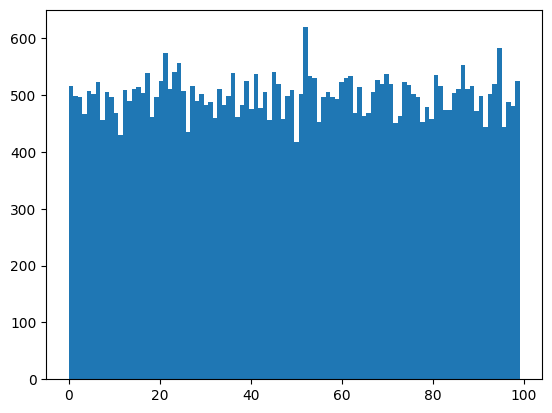

In [17]:
import matplotlib.pyplot as plt
plt.hist(predicted, bins=100)

In [19]:
len(torch.unique(y))

100

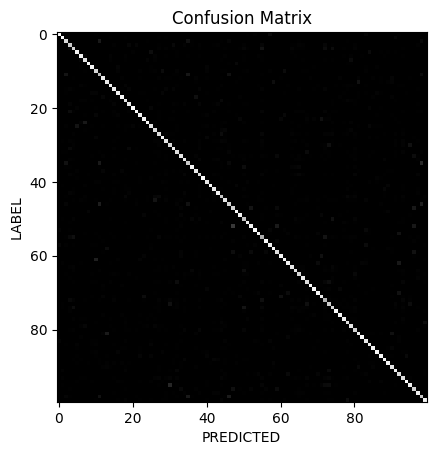

In [47]:
c = np.zeros((100,100))
for i in range(len(predicted)):    
    c[predicted[i]][labels[i]] += 1

plt.xlabel("PREDICTED")
plt.ylabel("LABEL")
plt.title("Confusion Matrix")
plt.imshow(c, cmap='Greys_r')

In [48]:
diagonal = np.sum(np.diag(c))

print(diagonal/len(predicted))


0.8171414852752881


In [73]:
for x in range(100):    
    top10 = np.argsort(-c[x])[:10]
    all = np.argsort(-c[x])
    print(top10)
    print(-np.sort(-c[x])[:10])  

    # also go and check the complementary   
    for i in all[1:]:
        #print(i, c[x][i], c[i][x])
        print(c[x][i] + c[i][x])







[ 0 57 83 53 10 92 51  7 32 54]
[467.  19.  11.   5.   3.   2.   2.   1.   1.   1.]
31.0
19.0
13.0
4.0
2.0
3.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[ 1 91 18 14 29 27 78 33 73 40]
[455.  12.   3.   3.   2.   2.   1.   1.   1.   1.]
18.0
3.0
3.0
4.0
3.0
1.0
1.0
3.0
1.0
1.0
1.0
2.0
2.0
1.0
1.0
3.0
1.0
2.0
1.0
1.0
3.0
1.0
1.0
1.0
2.0
1.0
5.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
2.0
0.0
5.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
1.0
0.0
[ 2 11 35 98 46 78 36 44 24 65]
[366

In [92]:
costs = []
arrays = []

for x in range(100):    
    # print(c[:,x])
    # print(c[x,:])
    tot = c[:,x]+c[x,:]
    #print(tot)
    sorted = np.argsort(-tot)
    print(sorted[0:11])
    print(tot[sorted][1:11])

    sum_tot = np.sum(tot[sorted][1:11])
    print(sum_tot)

    costs.append(sum_tot)
    arrays.append(sorted[0:11])


[ 0 57 83 53 10 51 92  4 69 77  2]
[31. 19. 13.  4.  3.  2.  1.  1.  1.  1.]
76.0
[ 1 91 62 93 29 50 32 27 18 14 73]
[18.  5.  5.  4.  3.  3.  3.  3.  3.  3.]
50.0
[ 2 11 35 98 46 65 36 25 57 84 44]
[76. 58. 24. 21.  5.  5.  5.  5.  4.  4.]
207.0
[ 3 21 31 55 72  4 19 43 38 15 34]
[32. 28. 28. 27. 22. 21. 12. 12. 11. 10.]
203.0
[ 4 55 74 72  3 50 63 80 27 77 64]
[56. 40. 27. 22. 16. 16. 11. 10.  7.  7.]
212.0
[ 5 25 84 20 89 37 87 39 85 94 91]
[55. 25. 11.  5.  5.  4.  4.  3.  3.  3.]
118.0
[ 6  7 14 79 18 45 26 24 82 93 54]
[19. 12.  9.  9.  8.  7.  7.  6.  6.  5.]
88.0
[ 7 24 79  6 44 18 14 26 41 72 74]
[48. 29. 19.  7.  7.  7.  6.  5.  4.  3.]
135.0
[ 8 48 89 79 46 78 85 38 41 44 70]
[25.  4.  3.  3.  2.  2.  2.  2.  1.  1.]
45.0
[ 9 16 40 86 10 25 83 67 57  6 87]
[20. 10.  6.  5.  5.  4.  4.  3.  3.  2.]
62.0
[10 61 28 22 16 40 32 83 57 51  9]
[70. 30. 17. 14. 10.  7.  7.  7.  5.  5.]
172.0
[11 35  2 46 98 40 64 55 32 31 10]
[80. 76. 75. 49.  5.  4.  4.  4.  3.  2.]
302.0
[12 37 90

In [105]:
print(costs)
ordered_arr = np.argsort(-np.array(costs))
print(np.array(costs)[ordered_arr][:10])

print(np.array(arrays)[ordered_arr][:10])

[76.0, 50.0, 207.0, 203.0, 212.0, 118.0, 88.0, 135.0, 45.0, 62.0, 172.0, 302.0, 108.0, 163.0, 69.0, 108.0, 98.0, 92.0, 103.0, 118.0, 55.0, 100.0, 87.0, 124.0, 98.0, 138.0, 125.0, 142.0, 87.0, 99.0, 214.0, 107.0, 117.0, 121.0, 117.0, 310.0, 98.0, 99.0, 145.0, 39.0, 94.0, 52.0, 92.0, 99.0, 179.0, 123.0, 274.0, 256.0, 67.0, 91.0, 202.0, 63.0, 245.0, 70.0, 93.0, 237.0, 60.0, 109.0, 83.0, 215.0, 115.0, 126.0, 147.0, 98.0, 130.0, 109.0, 80.0, 172.0, 51.0, 61.0, 117.0, 164.0, 223.0, 220.0, 199.0, 44.0, 63.0, 73.0, 114.0, 103.0, 142.0, 160.0, 42.0, 121.0, 91.0, 57.0, 69.0, 83.0, 74.0, 79.0, 121.0, 103.0, 170.0, 133.0, 54.0, 198.0, 227.0, 87.0, 308.0, 95.0]
[310. 308. 302. 274. 256. 245. 237. 227. 223. 220.]
[[35 98 11  2 46 21 40  6 44 38 50]
 [98 35 46 11  2 21 32  3 65 45 36]
 [11 35  2 46 98 40 64 55 32 31 10]
 [46 98 11 35  2 32 21 87 84 13 30]
 [47 52 96 59 33 56 70 37 82 28 26]
 [52 47 59 96 33 56 49 60 37 31 29]
 [55 72  4  3 27 74 95 21 38 80 30]
 [96 47 59 52 33 56 37 18 49 65 74]
 [7

In [23]:
## majority voting for each class
b = np.argmax(a, axis=0)

c = np.zeros((centroids.shape[0],100))
for x in range(100):    
    c[b[x]][x] = 1

plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")
plt.title("Majority belonging to a cluster for every label class number of clustering = " + str(centroids.shape[0]))
plt.imshow(c, cmap='Greys_r')

NameError: name 'a' is not defined

In [44]:
# use the second matrix as a mask 

false_negative = np.sum(np.ma.array(a,mask=c))
print(false_negative)

15193.0


In [46]:
false_negative/clusters.shape[0]

0.3039572663252241

In [17]:
# map each line to cluster: label to cluster belonging

maps = {}

for i, x in enumerate(c):
    for j, y in enumerate(x):
        if(y==1):
            maps[j] = i
    
print(maps)

{0: 0, 1: 0, 53: 0, 54: 0, 57: 0, 62: 0, 70: 0, 82: 0, 83: 0, 92: 0, 4: 1, 27: 1, 29: 1, 32: 1, 44: 1, 50: 1, 51: 1, 63: 1, 64: 1, 74: 1, 75: 1, 77: 1, 78: 1, 80: 1, 2: 2, 5: 2, 11: 2, 20: 2, 25: 2, 35: 2, 36: 2, 39: 2, 46: 2, 84: 2, 86: 2, 87: 2, 94: 2, 98: 2, 3: 3, 15: 3, 19: 3, 21: 3, 31: 3, 34: 3, 38: 3, 42: 3, 43: 3, 65: 3, 66: 3, 88: 3, 97: 3, 6: 4, 7: 4, 14: 4, 18: 4, 24: 4, 26: 4, 45: 4, 79: 4, 30: 5, 55: 5, 67: 5, 72: 5, 73: 5, 91: 5, 93: 5, 95: 5, 9: 6, 10: 6, 16: 6, 22: 6, 23: 6, 28: 6, 40: 6, 60: 6, 61: 6, 69: 6, 71: 6, 99: 6, 12: 7, 17: 7, 37: 7, 49: 7, 68: 7, 76: 7, 90: 7, 8: 8, 13: 8, 41: 8, 48: 8, 58: 8, 81: 8, 85: 8, 89: 8, 33: 9, 47: 9, 52: 9, 56: 9, 59: 9, 96: 9}


In [28]:
np.sum(c, axis=1)

array([ 8.,  7.,  9.,  7., 19.,  8.,  6., 18.,  6., 12.])